# AI for Trading: A Simple Pattern-Detecting "Trading Bot"

In this notebook we will **not** build a production-ready trading bot.  
Instead, we will use a **very simplified example** to show how AI / machine learning can:

1. Load historical price data from a well-known market (S&P 500 ETF: `SPY`)
2. Visualize the data and some simple indicators
3. Turn the problem into a **prediction task** (e.g. "Will the price go up tomorrow?")
4. Train different models, including a simple **neural network**, to detect patterns
5. Evaluate and reflect on the results and limitations

> ⚠️ **Important disclaimer**  
> This notebook is for **educational purposes only**.  
> It is **not** financial advice and must **not** be used for real-money trading decisions.


In [1]:
# If you're running this in a fresh environment, uncomment the line below to install dependencies:
# !pip install yfinance pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ai_trader.data_grabber import download_price_data
from ai_trader.inidicators import IndicatorEngineer
from ai_trader.plotting import IndicatorPlotter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


## 2. Visualizing the price history

To get some intuition, we'll:
- Plot the **closing price** over time.
- Add a couple of **moving averages**, which are common technical indicators:
  - 20-day moving average (short-term)
  - 50-day moving average (medium-term)

These are simple examples of hand-crafted **features** that traders use to detect trends.

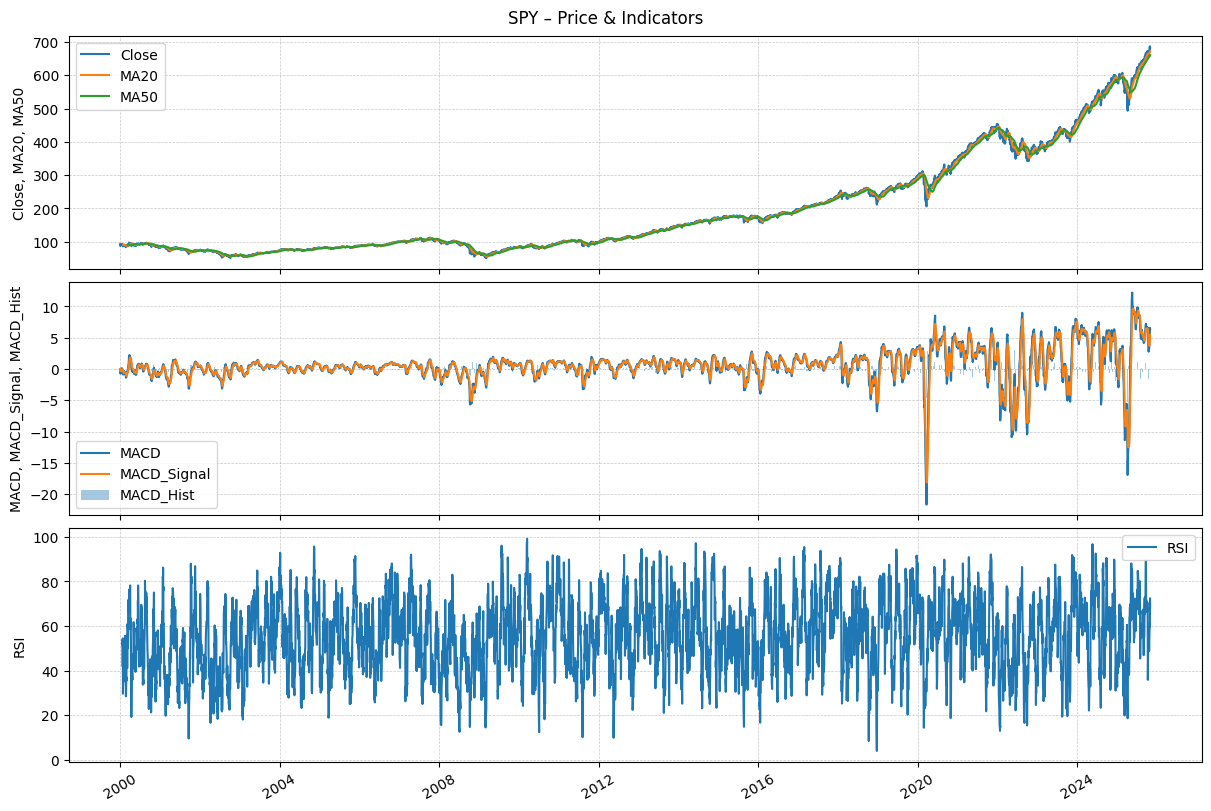

In [4]:
data = download_price_data("SPY", start="2000-01-01", end="2025-11-01", interval="1d")

data_with_indicators = IndicatorEngineer(data).add_basic_demo_indicators().data

plotter = IndicatorPlotter(data_with_indicators, price_col="Close")
fig = plotter.plot_panels(title="SPY – Price & Indicators")
plt.show()


In [5]:
data_with_indicators

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,Return_1d,Return_5d_mean,Return_20d_mean,MA20,MA50,Dist_MA20,Dist_MA50,Volatility_10d,RSI,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00-05:00,93.664677,93.664677,90.900543,91.887733,8164300,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
2000-01-04 00:00:00-05:00,90.683422,91.019067,88.225315,88.294418,8089800,0.0,0.0,0.0,-0.039105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.286646,-0.057329,-0.229317
2000-01-05 00:00:00-05:00,88.412882,89.419817,86.714912,88.452370,12177900,0.0,0.0,0.0,0.001789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.495360,-0.144935,-0.350424
2000-01-06 00:00:00-05:00,88.215422,89.400052,87.030792,87.030792,6227200,0.0,0.0,0.0,-0.016072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.766639,-0.269276,-0.497363
2000-01-07 00:00:00-05:00,88.649801,92.085228,88.491851,92.085228,8066500,0.0,0.0,0.0,0.058076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.567240,-0.328869,-0.238371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-27 00:00:00-04:00,682.729980,685.539978,682.119995,685.239990,63339800,0.0,0.0,0.0,0.011798,0.004137,0.001637,668.559494,657.755620,0.024950,0.041785,0.006378,60.894854,5.027160,4.019284,1.007876
2025-10-28 00:00:00-04:00,687.049988,688.909973,684.830017,687.059998,61738100,0.0,0.0,0.0,0.002656,0.004671,0.001582,669.603494,658.666392,0.026070,0.043108,0.006186,59.713157,5.913044,4.398036,1.515008
2025-10-29 00:00:00-04:00,688.719971,689.700012,682.869995,687.390015,85657100,0.0,0.0,0.0,0.000480,0.005807,0.001435,670.550494,659.653370,0.025113,0.042047,0.006260,61.561525,6.566054,4.831640,1.734414


In [ ]:
# Use a time-based split instead of random shuffling
split_index = int(len(X) * 0.7)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
y_buy_train,  y_buy_test  = y_buy.iloc[:split_index],  y_buy.iloc[split_index:]
y_sell_train, y_sell_test = y_sell.iloc[:split_index], y_sell.iloc[split_index:]

len(X_train), len(X_test)

(5730, 2457)

## 5. Baseline models: "dumb" strategies

Before using AI, it's good practice to compare against simple baselines:

1. **Naive predictor**: Always predicts "up".
   - Markets have a long-term upward drift, so this is not completely stupid.

2. **Logistic Regression**: A simple **linear model** (not yet a neural network).
   - It tries to find a linear combination of features that best separates "up" vs "down" days.

These baselines help us check if our more complex models are actually learning something useful.


In [ ]:
# Baseline 1: always predict "up"
y_pred_always_up = np.ones_like(y_test)
acc_always_up = accuracy_score(y_test, y_pred_always_up)
print(f"Baseline (always predict 'up') accuracy: {acc_always_up:.3f}")

# Baseline 2: Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_log_reg = log_reg.predict(X_test)
acc_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression accuracy: {acc_log_reg:.3f}")

print("\nClassification report (Logistic Regression):")
print(classification_report(y_test, y_pred_log_reg, digits=3))


Baseline (always predict 'up') accuracy: 0.624
Logistic Regression accuracy: 0.497

Classification report (Logistic Regression):
              precision    recall  f1-score   support

           0      0.381     0.543     0.448       923
           1      0.630     0.469     0.538      1534

    accuracy                          0.497      2457
   macro avg      0.505     0.506     0.493      2457
weighted avg      0.536     0.497     0.504      2457



## 6. Random Forest: a non-linear ensemble model

Next, we try a **Random Forest**, which is:
- A collection (ensemble) of decision trees.
- Each tree captures non-linear rules like:  
  “If the price is far above the moving average AND recent returns are negative, then…”
- The forest averages across many trees to reduce overfitting.

This is not yet a neural network, but it **can detect more complex patterns** than a linear model.


Random Forest accuracy: 0.453

Classification report (Random Forest):
              precision    recall  f1-score   support

           0      0.368     0.637     0.466       923
           1      0.610     0.342     0.438      1534

    accuracy                          0.453      2457
   macro avg      0.489     0.489     0.452      2457
weighted avg      0.519     0.453     0.449      2457



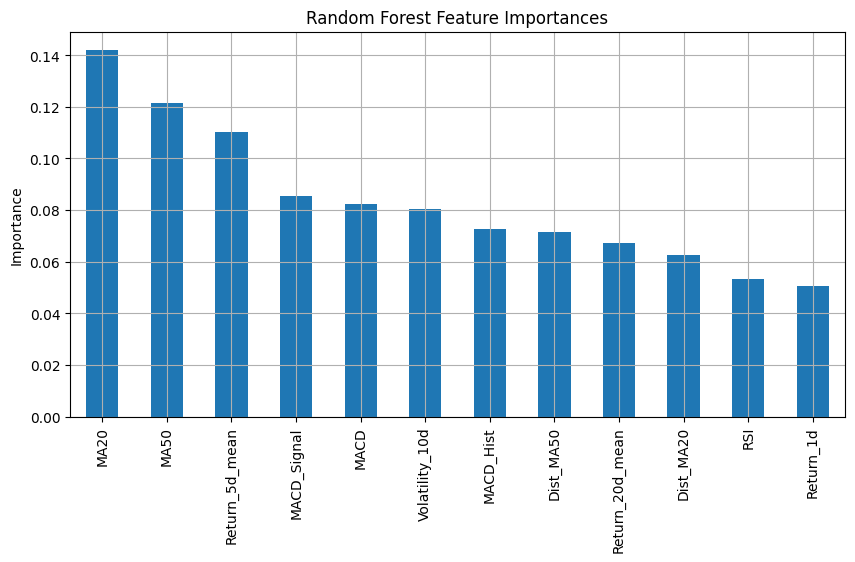

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest accuracy: {acc_rf:.3f}")

print("\nClassification report (Random Forest):")
print(classification_report(y_test, y_pred_rf, digits=3))

# Feature importance plot
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
plt.figure()
importances.plot(kind="bar")
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.show()


## 7. A simple Neural Network (MLPClassifier)

Now we build a **small neural network** using scikit-learn's `MLPClassifier`:

- It is a **feedforward neural network** (also called a multilayer perceptron).
- Architecture:
  - Input layer: one neuron per feature
  - Hidden layer(s): neurons with non-linear activation functions
  - Output layer: predicts probability of "up" (1) vs "down" (0)

Even though this is much simpler than the huge networks used in modern AI (like GPT or large vision models),
it illustrates the same **core idea**: learning complex mappings from inputs to outputs by adjusting weights.


In [ ]:
X_train


,Return_1d,Return_5d_mean,Return_20d_mean,MA20,MA50,Dist_MA20,Dist_MA50,Volatility_10d,RSI,MACD,MACD_Signal,MACD_Hist
Date,,,,,,,,,,,,
1993-04-12 00:00:00-04:00,0.014114,0.003676,0.000051,24.918490,24.765493,0.001925,0.008115,0.008927,51.923113,-0.021188,0.020790,-0.041979
1993-04-13 00:00:00-04:00,0.002088,0.003101,-0.000088,24.915723,24.779604,0.004128,0.009644,0.008843,51.922707,-0.003705,0.015891,-0.019596
1993-04-14 00:00:00-04:00,-0.001389,0.003388,-0.000157,24.911220,24.789562,0.002915,0.007837,0.008787,50.943271,0.007263,0.014166,-0.006902
1993-04-15 00:00:00-04:00,0.000000,0.002681,0.000153,24.914498,24.798482,0.002783,0.007475,0.008789,46.392002,0.015774,0.014487,0.001287
1993-04-16 00:00:00-04:00,0.000000,0.002963,-0.000159,24.909994,24.802214,0.002964,0.007323,0.008728,50.562121,0.022263,0.016042,0.006220
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-01-04 00:00:00-05:00,-0.013979,-0.004537,-0.000768,173.704953,175.011860,-0.016288,-0.023634,0.010920,50.591414,-0.311243,-0.220144,-0.091100
2016-01-05 00:00:00-05:00,0.001691,-0.003741,-0.001658,173.406597,174.966203,-0.012929,-0.021727,0.009245,49.384842,-0.485542,-0.273223,-0.212319
2016-01-06 00:00:00-05:00,-0.012614,-0.008399,-0.001986,173.053945,174.839340,-0.023394,-0.033366,0.009696,41.083885,-0.788801,-0.376339,-0.412462


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model A – Strong Buy
mlp_buy = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation="relu",
    solver="adam",
    max_iter=2000,
    random_state=42,
)
mlp_buy.fit(X_train_scaled, y_buy_train)

# Model B – Strong Sell
mlp_sell = MLPClassifier(
    hidden_layer_sizes=(64, 32, 16),
    activation="relu",
    solver="adam",
    max_iter=2000,
    random_state=42,
)

mlp_sell.fit(X_train_scaled, y_train)

proba_buy  = mlp_buy.predict_proba(X_test_scaled)[:, 1]
proba_sell = mlp_sell.predict_proba(X_test_scaled)[:, 1]

# acc_mlp = accuracy_score(y_test, y_pred_mlp)

# print(f"Neural Network (MLP) accuracy: {acc_mlp:.3f}")

# print("\nClassification report (Neural Network):")
# print(classification_report(y_test, y_pred_mlp, digits=3))

# # Confusion matrix to see types of errors
# cm = confusion_matrix(y_test, y_pred_mlp)
# cm


Neural Network (MLP) accuracy: 0.509

Classification report (Neural Network):
              precision    recall  f1-score   support

           0      0.392     0.560     0.461       923
           1      0.644     0.478     0.548      1534

    accuracy                          0.509      2457
   macro avg      0.518     0.519     0.505      2457
weighted avg      0.549     0.509     0.516      2457



array([[517, 406],
       [801, 733]])

## 8. Visualizing predictions over time

For intuition, we can plot:
- The actual direction (up/down) of the market
- The neural network's predicted direction

This helps illustrate when the model is in sync with the market and when it is not.


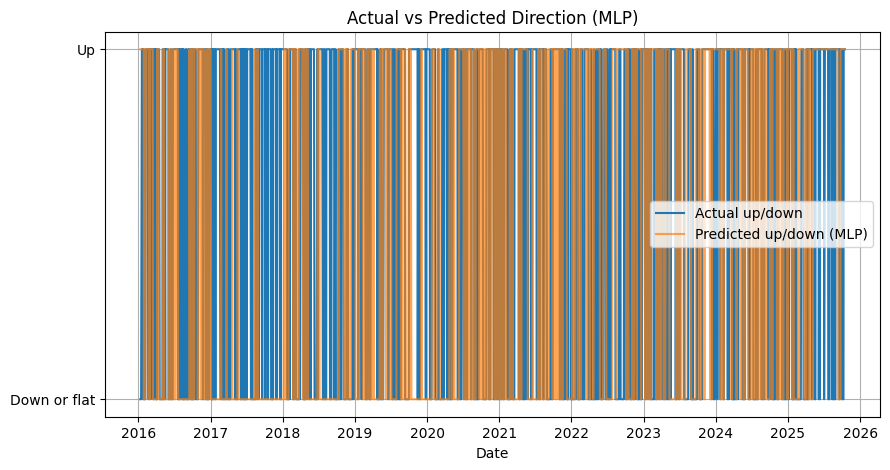

In [ ]:
results = pd.DataFrame(index=X_test.index)
results["Actual_Up"] = y_test
results["Predicted_Up_MLP"] = y_pred_mlp

# Convert 0/1 to -1/1 for visualization (down = -1, up = 1)
results["Actual_Signal"] = results["Actual_Up"].replace({0: -1, 1: 1})
results["Pred_Signal"] = results["Predicted_Up_MLP"].replace({0: -1, 1: 1})

plt.figure()
plt.plot(results.index, results["Actual_Signal"], label="Actual up/down")
plt.plot(results.index, results["Pred_Signal"], label="Predicted up/down (MLP)", alpha=0.7)
plt.title("Actual vs Predicted Direction (MLP)")
plt.yticks([-1, 1], ["Down or flat", "Up"])
plt.xlabel("Date")
plt.legend()
plt.show()


## 9. From prediction to a (very naive) trading strategy

If we wanted to turn predictions into a simple **strategy**, we could say:

- If the model predicts **up** → go **long** (buy).
- If the model predicts **down** → go **flat** (hold cash).

We can simulate the cumulative return of this naive strategy and compare it to
just "buy and hold" SPY (this is still just a toy example).


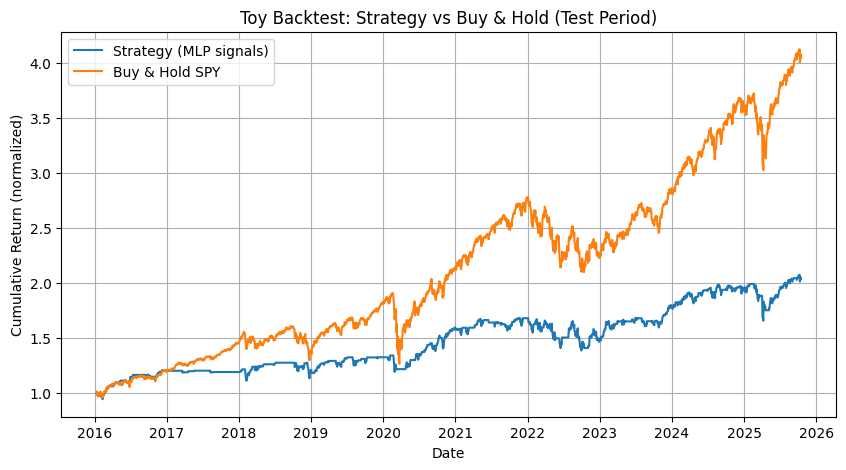

In [ ]:
# Use the test period's actual returns
test_returns = data_ml.loc[X_test.index, "Return_1d"]

# Strategy: if Predicted_Up_MLP == 1, we take the daily return; else, return 0
strategy_returns = test_returns * results["Predicted_Up_MLP"]

# Buy & hold benchmark: always invested
buy_hold_returns = test_returns

# Compute cumulative returns
cum_strategy = (1 + strategy_returns).cumprod()
cum_buy_hold = (1 + buy_hold_returns).cumprod()

plt.figure()
plt.plot(cum_strategy.index, cum_strategy, label="Strategy (MLP signals)")
plt.plot(cum_buy_hold.index, cum_buy_hold, label="Buy & Hold SPY")
plt.title("Toy Backtest: Strategy vs Buy & Hold (Test Period)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return (normalized)")
plt.legend()
plt.show()


## 10. Interpretation & limitations

### What did the AI models do?

- They **did not** magically "understand" the market.
- They saw **historical patterns** in numerical features:
  - Recent returns
  - Moving averages
  - Distance from moving averages
- Based on these patterns, they learned to estimate the probability that
  **tomorrow's price** would be higher than **today's**.

### Why this is *not* a real trading bot

- We used a **tiny dataset** and very few features.
- We ignored:
  - Transaction costs and slippage
  - Risk management (position sizing, stop losses)
  - Market regimes (volatile vs calm periods)
  - Robust backtesting techniques (walk-forward, cross-validation in time, etc.)
- Real trading systems require **much more careful design, validation, and risk control**.

### Educational takeaway

This notebook shows how AI / ML:
- Takes **raw data** (prices) → transforms it into **features**.
- Defines a **prediction target** based on future outcomes.
- Trains different **models** (linear, tree-based, neural network) to detect patterns.
- Evaluates performance on **unseen data** to estimate how useful those patterns might be.

In your AI presentation/workshop, you can now:
- Walk through each block and explain the concept at a high level.
- Emphasize that the goal is **learning patterns from data**, not hand-coding rules.
- Highlight both the **power** and the **limitations** of AI in real-world domains like trading.
